In [3]:
import pandas as np
import numpy as np

a = np.random.random((5,1))
b = np.random.random((4,1))

In [51]:
import pandas as pd
import ast
train = pd.read_csv("../input/rsna-breast-cancer-detection/full_label_final.csv")

train.results = train.results.apply(ast.literal_eval)
# train[train.results == []]

In [54]:
train[train.results == '[]']

,id,results
14338,25323_1743461841.png,[]
22167,33581_1586149541.png,[]
22170,33581_357843412.png,[]
33897,46373_689012688.png,[]
37438,50203_643148078.png,[]
39401,52509_1072010415.png,[]
39406,52509_775490405.png,[]
39407,52509_910813610.png,[]
39408,52509_930239507.png,[]


100%|██████████| 54706/54706 [00:00<00:00, 495933.59it/s]


torch.Size([3, 512, 512])


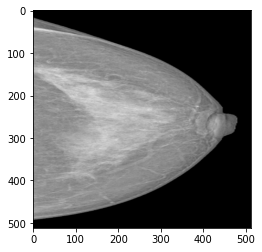

torch.Size([3, 512, 512])


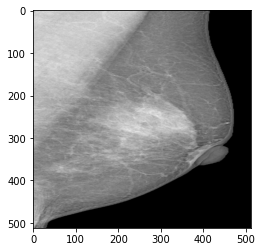

torch.Size([3, 512, 512])


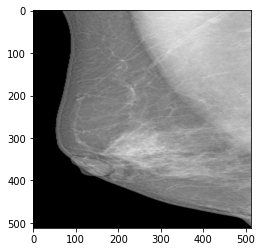

torch.Size([3, 512, 512])


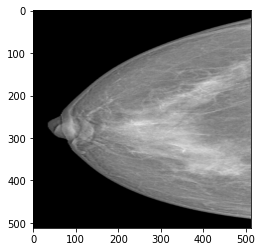

torch.Size([3, 512, 512])


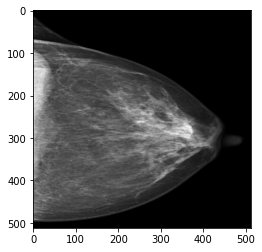

torch.Size([3, 512, 512])


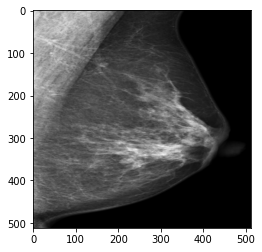

In [44]:
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
from config import CFG
from itertools import chain
from tqdm import tqdm
import albumentations as albu
from albumentations.pytorch import ToTensorV2
import pickle
from ast import literal_eval
def get_train_transfos(augment=True, visualize=False):
    """
    Returns transformations.

    Args:
        augment (bool, optional): Whether to apply augmentations. Defaults to True.
        visualize (bool, optional): Whether to use transforms for visualization. Defaults to False.

    Returns:
        albumentation transforms: transforms.
    """
    return albu.Compose([
            albu.Resize(CFG.size, CFG.size),
            # albu.CLAHE(p=0.3),
            # albu.OneOf([
            #     albu.Rotate(30, p=0.3),
            #     albu.HorizontalFlip(0.3),
            #     albu.VerticalFlip(0.3),],
            #      p=0.5),
            # albu.OneOf([
            #     albu.IAAAdditiveGaussianNoise(),   # 将高斯噪声添加到输入图像
            #     albu.GaussNoise(),    # 将高斯噪声应用于输入图像。
            #             ], p=0.2),   # 应用选定变换的概率
            # albu.OneOf([
            #     albu.MotionBlur(p=0.2),   # 使用随机大小的内核将运动模糊应用于输入图像。
            #     albu.MedianBlur(blur_limit=3, p=0.1),    # 中值滤波
            #     albu.Blur(blur_limit=3, p=0.1),   # 使用随机大小的内核模糊输入图像。
            #             ], p=0.2),
            # albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
            # 随机应用仿射变换：平移，缩放和旋转输入
            # albu.RandomBrightnessContrast(p=0.2),   # 随机明亮对比度

            # albu.Normalize(mean=0, std=1.),
            ToTensorV2(),
            ],
        p=1,
    )

def get_valid_transfos(augment=True, visualize=False):
    """
    Returns transformations.

    Args:
        augment (bool, optional): Whether to apply augmentations. Defaults to True.
        visualize (bool, optional): Whether to use transforms for visualization. Defaults to False.

    Returns:
        albumentation transforms: transforms.
    """
    return albu.Compose([
            albu.Resize(CFG.size, CFG.size),
            albu.Normalize(mean=0, std=1),
            ToTensorV2(),
        ],
        p=1,
    )

class TrainDataset(Dataset):
    """
    Image torch Dataset.
    """
    def __init__(
        self,
        cfg,
        df,
        transforms=get_valid_transfos(),
        mode = 'train'
    ):
        """
        Constructor

        Args:
            paths (list): Path to images.
            transforms (albumentation transforms, optional): Transforms to apply. Defaults to None.
        """
        self.config = cfg
        self.anns = pd.read_csv('../input/rsna-breast-cancer-detection/full_label_final.csv')
        self.paths = df['path'].values
        self.transforms = transforms
        self.targets = df['cancer'].values
        if mode == 'train':
            label_to_count = {0:20, 1:10}
            self.weights = [1.0 / label_to_count[target]
                   for target in tqdm(self.targets, total=len(self.targets))]



    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        """
        Item accessor

        Args:
            idx (int): Index.

        Returns:
            np array [H x W x C]: Image.
            torch tensor [1]: Label.
            torch tensor [1]: Sample weight.
        """

        image = cv2.imread(self.paths[idx])[..., ::-1]
        image = np.ascontiguousarray(image)
        file_name = self.paths[idx].split('/')[-1]
        anns = self.anns[self.anns.id == file_name].results.values[0]
       
        anns = literal_eval(anns)[0]
    
        x_min, x_max, y_min, y_max = int(anns['xmin']), int(anns['xmax']), int(anns['ymin']), int(anns['ymax'])
 
        image = image[y_min:y_max, x_min:x_max, :]
        if self.transforms:
            image = self.transforms(image=image)["image"]

        if 'bce' in self.config.loss_config['name']:
            y = torch.tensor([self.targets[idx]], dtype=torch.float)
        else:
            y = torch.tensor(self.targets[idx], dtype=torch.long)
        # w = torch.tensor([1])

        return image, y

from typing import Callable

import pandas as pd
import torch
import torch.utils.data
import torchvision


if __name__ == "__main__":
    import pandas as pd
    import numpy as np
    from tqdm import tqdm
    from torch.utils.data import DataLoader
    import matplotlib.pyplot as plt
    SAVE_FOLDER = '../input/rsna-breast-cancer-detection/train_images/'
    
    path = '../input/rsna-breast-cancer-detection/train.csv'

    train = pd.read_csv(path)
    train['path'] = SAVE_FOLDER + train["patient_id"].astype(str) + "_" + train["image_id"].astype(str) + ".png"
    train_dataset = TrainDataset(CFG, train, get_train_transfos())

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.data_config['batch_size'],
                              shuffle=False,
                            #   sampler=ImbalancedDatasetSampler(train_dataset),
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    
    for idx, (i,j) in enumerate(train_dataset):
        # pass
        print(i.shape)
        plt.imshow(i.permute(1,2,0))
        plt.show()
        
        if idx == 5:
            break

                            